# Visualising Simplicial Laplacian 1-Eigenvectors

In this notebook, we develop a few examples of using de rham networks to visualise the 1-eigenvectors of the simplicial laplacian.

In [1]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors


from sklearn.datasets import make_circles
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd

# for building the boundary matrices
from scipy import sparse
from scipy.sparse import coo_matrix,diags

import cochainlearning as cl

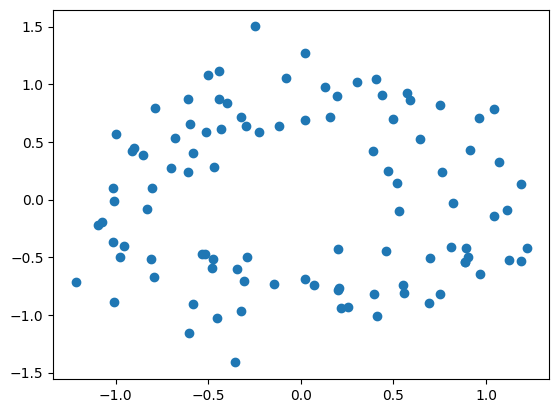

In [2]:
# Initialise some noisey circles
data =  make_circles(n_samples=100, shuffle=True, noise=0.2, random_state=None, factor=0.8)[0]
plt.scatter(data[:,0], data[:,1])
plt.show()

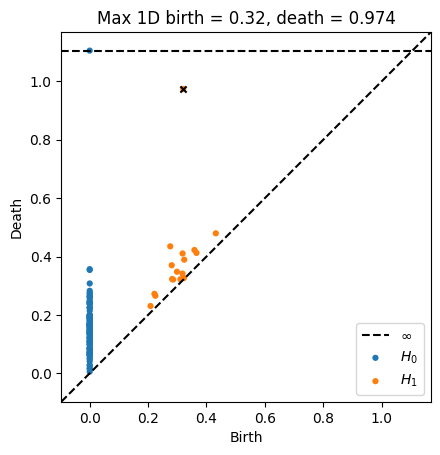

In [3]:
# find a good threshold for the data 
result = ripser(data, coeff=3, do_cocycles=True, maxdim =1)
diagrams = result['dgms']
cocycles = result['cocycles']
dgm1 = diagrams[1]

# identify the index of the longest interval
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])

# store the corresponding cocycle
cocycle = cocycles[1][idx]

# plot diagram with longest interval highlighted
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

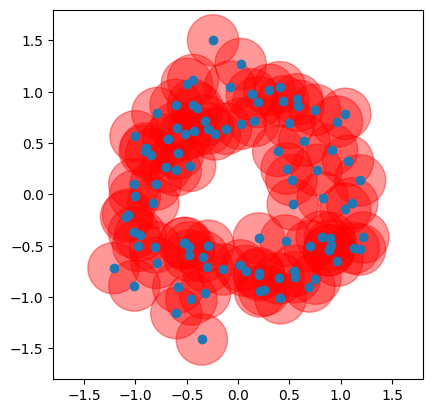

In [13]:

for i in range(len(data)):
    plt.gca().add_artist(plt.Circle(data[i], 0.5/2, color='r', fill=True, alpha = 0.4))

# plot a ball of radius 0.5 around each point in data
plt.scatter(data[:,0], data[:,1])

# make the plot square
plt.axis('square')

# set the limits of the plot
plt.xlim([-1.8, 1.8])
plt.ylim([-1.8, 1.8])

# save the plot
plt.savefig('./figures/1-eigenvectors/rips.png', dpi=300)

plt.show()


In [14]:
# build a simplex tree
Rips_complex_sample = gd.RipsComplex(points = data, max_edge_length=0.5)
st = Rips_complex_sample.create_simplex_tree(max_dimension=2)

# extract simplices
simplices = cl.extract_simplices(st)

# build the boundary matrices and laplacian
boundaries = cl.build_boundaries(simplices)
laplacian = boundaries[0].T @ boundaries[0] + boundaries[1] @ boundaries[1].T

In [15]:
laplacian

<636x636 sparse matrix of type '<class 'numpy.float32'>'
	with 6186 stored elements in Compressed Sparse Row format>

In [16]:
laplacian = np.array(laplacian.todense())
laplacian.shape

(636, 636)

In [17]:
# only calculate the first 10 eigenvectors of the laplacian corresponding to the first 10 eigenvalues without calculating the full set of eigenvectors
eigvals, eigvecs = sparse.linalg.eigsh(laplacian, k=10, which='SM')

In [18]:
eigvecs = torch.tensor(eigvecs).float()

## Representing the simplicial complex as a chain

In [19]:
# a function for turning a path into a chain
def complex_to_chain(one_simplices, points):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A set of 1-simplices extracted from the Gudhi simplex tree

    points : numpy array
        A set of vertices corresponding to the embedding

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(one_simplices)

    n = points[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    for i in range(r):

        chain[i,0,:] = torch.tensor(points[one_simplices[i][0]])
        chain[i,1,:] = torch.tensor(points[one_simplices[i][1]])
    

    return chain

In [20]:
# extract simpices
simplices = cl.extract_simplices(st)

one_simplices = [np.sort(list(elem)) for elem in simplices[1].keys()]


one_simplices
chain = complex_to_chain(one_simplices, data)
chain.shape

torch.Size([636, 2, 2])

In [21]:
data[one_simplices[0][1]]

array([-0.39854044,  0.8399133 ])

In [22]:
chain.shape
one_simplices

[array([0, 6]),
 array([0, 7]),
 array([ 0, 16]),
 array([ 0, 34]),
 array([ 0, 37]),
 array([ 0, 39]),
 array([ 0, 45]),
 array([ 0, 46]),
 array([ 0, 64]),
 array([ 0, 65]),
 array([ 0, 66]),
 array([ 0, 67]),
 array([ 0, 68]),
 array([ 0, 69]),
 array([ 0, 71]),
 array([ 0, 73]),
 array([ 0, 85]),
 array([ 0, 87]),
 array([ 0, 93]),
 array([1, 5]),
 array([1, 9]),
 array([ 1, 13]),
 array([ 1, 14]),
 array([ 1, 30]),
 array([ 1, 31]),
 array([ 1, 41]),
 array([ 1, 43]),
 array([ 1, 50]),
 array([ 1, 52]),
 array([ 1, 62]),
 array([ 1, 72]),
 array([ 1, 74]),
 array([ 1, 76]),
 array([ 1, 80]),
 array([ 1, 89]),
 array([2, 6]),
 array([2, 7]),
 array([ 2, 37]),
 array([ 2, 39]),
 array([ 2, 40]),
 array([ 2, 46]),
 array([ 2, 54]),
 array([ 2, 64]),
 array([ 2, 65]),
 array([ 2, 87]),
 array([ 2, 90]),
 array([ 2, 93]),
 array([ 3, 23]),
 array([ 3, 24]),
 array([ 3, 25]),
 array([ 3, 26]),
 array([ 3, 35]),
 array([ 3, 44]),
 array([ 3, 47]),
 array([ 3, 49]),
 array([ 3, 51]),
 arr

## Learning Vector Fields in R^2 which Correspond to the Eigenvectors of the Laplacian

In [23]:
c = 10 # number of features/columns in cochain data matrix (corresponds to 10 eigenvectors)

vf = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 30),
    nn.ReLU(),
    nn.Linear(30, 2*c)
)

### Do the Training

In [24]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)



In [25]:
epoch = 1000

for i in range(epoch):

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    X = cl.gen_CDM(vf,chain)
    diff = X - eigvecs
    L = torch.sum(torch.diag(diff @ diff.T))
    L.backward()
    optimizer.step()    # Does the update

    if i % 10 == 0:
        print("Iteration: ", i, "Loss: ", L)

Iteration:  0 Loss:  tensor(11.4267, grad_fn=<SumBackward0>)
Iteration:  10 Loss:  tensor(8.8016, grad_fn=<SumBackward0>)
Iteration:  20 Loss:  tensor(8.1218, grad_fn=<SumBackward0>)
Iteration:  30 Loss:  tensor(7.7906, grad_fn=<SumBackward0>)
Iteration:  40 Loss:  tensor(7.5547, grad_fn=<SumBackward0>)
Iteration:  50 Loss:  tensor(7.3799, grad_fn=<SumBackward0>)
Iteration:  60 Loss:  tensor(7.2537, grad_fn=<SumBackward0>)
Iteration:  70 Loss:  tensor(7.1589, grad_fn=<SumBackward0>)
Iteration:  80 Loss:  tensor(7.0836, grad_fn=<SumBackward0>)
Iteration:  90 Loss:  tensor(7.0212, grad_fn=<SumBackward0>)
Iteration:  100 Loss:  tensor(6.9668, grad_fn=<SumBackward0>)
Iteration:  110 Loss:  tensor(6.9175, grad_fn=<SumBackward0>)
Iteration:  120 Loss:  tensor(6.8712, grad_fn=<SumBackward0>)
Iteration:  130 Loss:  tensor(6.8273, grad_fn=<SumBackward0>)
Iteration:  140 Loss:  tensor(6.7846, grad_fn=<SumBackward0>)
Iteration:  150 Loss:  tensor(6.7429, grad_fn=<SumBackward0>)
Iteration:  160 Lo

In [26]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5, c = 10, resolution = 40):
    """ 
    A function for plotting a component of a vector field given a function f: R^2 -> R^2

    Parameters
    ----------
    f : a Pytorch Sequential object
        A function f: R^2 -> R^2, represented as a Pytorch Sequential object
    
    ax : matplotlib axis object
        The axis on which to plot the vector field

    comp : int
        The component of the vector field to plot

    x_range : float
        The range of x values to plot
    
    y_range : float
        The range of y values to plot

    Returns
    -------
    None
    """
    x = np.linspace(-x_range,x_range,resolution)
    y = np.linspace(-y_range,y_range,resolution)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((resolution,resolution))
    V = np.zeros((resolution,resolution))
    for i in range(resolution):
        for j in range(resolution):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()
            tv = f.forward(inp).reshape(2,c)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_13827/2472807549.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i+1)


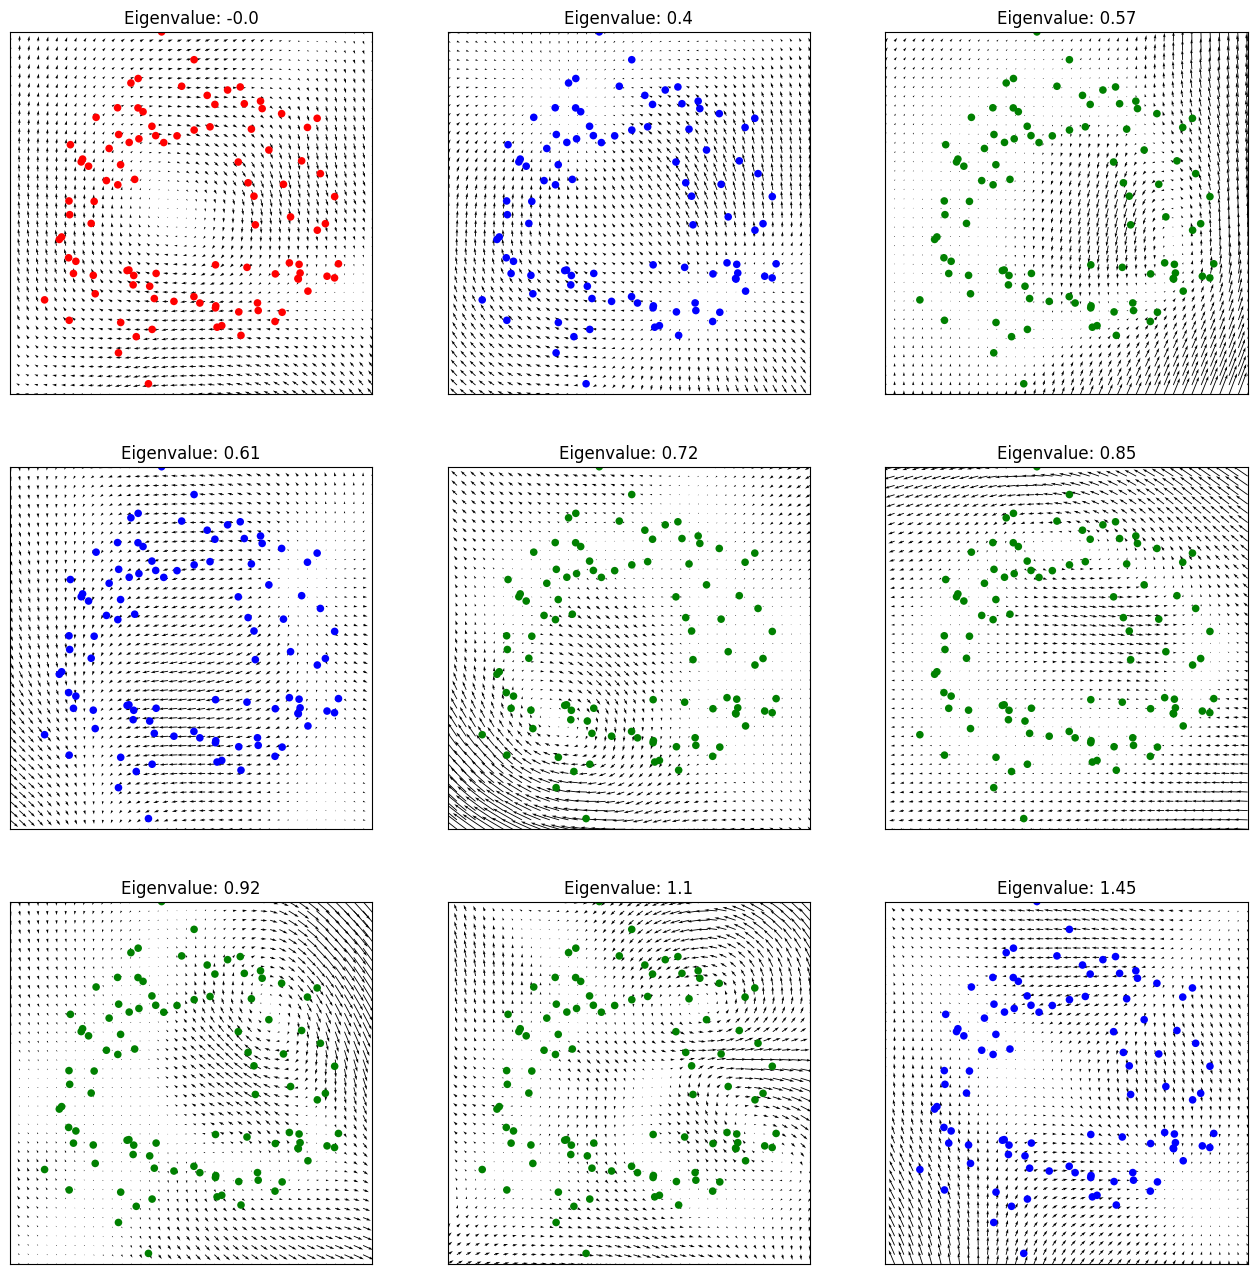

In [31]:
fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=1.5, y_range=1.5)


    # overlot the point cloud onto each subplot

    if i in [0]:
        ax.scatter(data[:,0], data[:,1], s=30, c='red', alpha=1, marker='o', edgecolors='none')
    elif i in [1,3,8]:   
        ax.scatter(data[:,0], data[:,1], s=30, c='blue', alpha=1, marker='o', edgecolors='none')
    else:
        ax.scatter(data[:,0], data[:,1], s=30, c='green', alpha=1, marker='o', edgecolors='none')
    
    # make the points a bit bigger
    


    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    # add a title to each subplot with i-th eigenvalue (up to 2 decimal places) corresponding to the i-th subplot 
    ax.set_title('Eigenvalue: ' + str(np.round(eigvals[i],2)))
    



# make the figure a bit bigger
fig.set_size_inches(16,16)


# save teh figure
plt.savefig('./figures/1-eigenvectors/learned-vf.png', dpi=300)


plt.show()

## Separating into rotational, harmonic and gradient parts

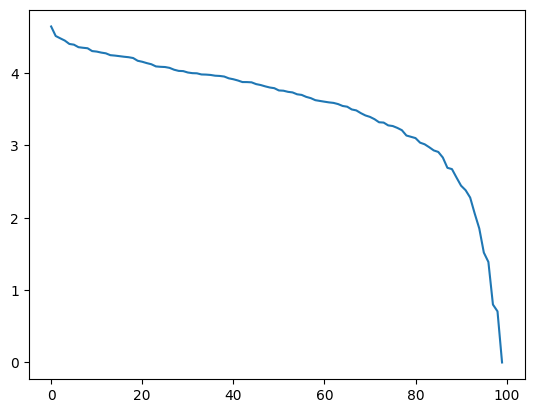

In [71]:
# do an SVD on the boundary matrix
U1, S1, V1 = np.linalg.svd(boundaries[0].todense())

plt.plot(S1)
plt.show()

In [78]:
boundaries[0].todense() @

(100, 665)

In [83]:
boundaries[0].todense() @ V1[0,:].T

matrix([[ 1.55352950e-01],
        [ 3.32276523e-02],
        [-4.26086411e-02],
        [ 1.02057904e-01],
        [-1.26981691e-01],
        [-3.47199067e-02],
        [ 8.11212347e-04],
        [-2.47459539e-04],
        [ 1.82221979e-01],
        [-1.45827681e-01],
        [-5.42225838e-01],
        [-9.61325504e-03],
        [-3.71211350e-01],
        [ 1.33774027e-01],
        [ 7.15883449e-04],
        [ 4.42406833e-02],
        [-2.31342509e-01],
        [ 1.08779452e-04],
        [-4.78291512e-03],
        [-3.56085509e-01],
        [ 1.75014036e-04],
        [ 6.65136278e-01],
        [ 2.26285798e-03],
        [ 4.46170829e-02],
        [-4.20828104e-01],
        [ 2.57413369e-02],
        [ 1.72296152e-01],
        [-2.28383005e-01],
        [-1.52510002e-01],
        [-4.87923861e-01],
        [-7.29152467e-03],
        [ 1.53410714e-03],
        [-2.91634798e-02],
        [-2.11294531e-03],
        [ 1.82709917e-02],
        [-6.23945729e-04],
        [-5.81333518e-01],
 

In [84]:
U1[0,:].T * S1[0]

matrix([[ 1.55352965e-01],
        [-1.82791591e-01],
        [ 4.04358387e-01],
        [-1.66805819e-01],
        [ 6.80876616e-03],
        [-1.51792258e-01],
        [ 4.97556365e-16],
        [ 1.04257919e-01],
        [-1.73469022e-01],
        [ 2.74732798e-01],
        [-1.25415269e-02],
        [-1.46821961e-01],
        [ 5.09546250e-02],
        [ 1.63813859e-01],
        [-6.88937424e-17],
        [-4.41443950e-01],
        [-3.42709094e-01],
        [-4.12976652e-01],
        [ 5.26992977e-01],
        [-5.50629944e-02],
        [-1.19286299e-01],
        [ 1.63208425e-01],
        [ 1.23162080e-14],
        [ 3.98310632e-01],
        [ 5.72036505e-01],
        [-1.66862011e-01],
        [-9.71172571e-01],
        [ 8.32965016e-01],
        [ 1.99342400e-01],
        [-3.71026486e-01],
        [-1.54947907e-01],
        [-3.04123249e-14],
        [-1.08381234e-01],
        [-2.69758552e-01],
        [-1.88599572e-01],
        [-9.47844759e-02],
        [-1.02833545e+00],
 

In [61]:
# do an SVD on the boundary matrix
U2, S2, V2 = np.linalg.svd(boundaries[1].todense())


In [62]:
U2.shape

(665, 665)

In [64]:
U2.shape

(665, 665)

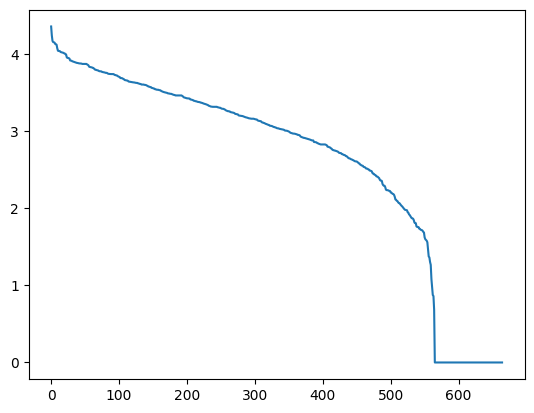

In [65]:
# plot S2
plt.plot(S2)
plt.show()